# Syntactictic features versus Surface statistics

I will also check in this notebook:
- Delta-beta coupling with TRFs
- Score of backwards model of acoustic versus linguistic features reconstrucitons
- Decoding fr/nl

In [3]:
import os
from audiobook.utils import SUBJECTS, subjects
from audiobook.utils import DATA_PATH
from audiobook import STORIES

import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

from source_TRF import get_feature_signal, load_raw, DATA_PATH, extract_story_parts_data, op, SUBJECTS, bads 

from pyeeg.models import TRFEstimator
from pyeeg.vizu import topomap
from tqdm.auto import tqdm
# Logging level of pyeeg to warning..
from pyeeg.utils import LOGGER
LOGGER.setLevel('WARNING')

import mne
from scipy.signal import coherence
from joblib import Parallel, delayed
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, make_scorer

fs = 50

def corr(y, yh):
    return np.corrcoef(y, yh, rowvar=False).diagonal(y.shape[1]).mean()

scorer = make_scorer(corr)

story_languages = ['nl'] * 9 + ['fr'] * 4

In [106]:
from scipy.stats import ttest_rel, ttest_1samp, ttest_ind
from statsmodels.stats.anova import anova_lm, summary2, anova_single
from statsmodels.regression import linear_model
from statsmodels.stats.api import local_fdr
from statsmodels.formula.api import glm, mixedlm, ols

In [4]:
print("Loading features...")
X = get_feature_signal(feats=['wordonsets', 'entropy', 'surprisal', 'depth', 'close'], srate=50, stories=STORIES.filename[:9].str.strip('.wav'), normalise='story')
# null stims
Xnoise = []
for k, x in enumerate(X):
    xn = x.copy()
    nonz = np.argwhere(xn[:, 0]) # non zero entries
    vals = xn[nonz] # only values
    xn[nonz] = np.roll(vals, -12, axis=0) #roll 12 words backwards
    Xnoise.append(xn)

Loading features...
Load stimulus features
Loading feature signal for : ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']
Done. X shape: (14900, 5)


In [190]:
subject = 'sub-026'#str(np.random.choice(SUBJECTS)) # sub-026
print("Loading Raws...")
raws = extract_story_parts_data(subject, ica=False, filter=(0.5, 12))
if fs!=raws[0].info['sfreq']:
    print("Resampling...")
    for k, r in tqdm(enumerate(raws), total=len(raws)):
        raws[k] = r.resample(fs, n_jobs=-2)
info = raws[0].info
picks = mne.pick_types(info, meg=True, ref_meg=False, exclude=bads)

Loading Raws...
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

## Scoring with cross-validation

In [118]:
def reverse_color(col):
    return [1-c for c in plt.cm.colors.to_rgb(col)]

In [191]:
scores = pd.DataFrame(columns=['score', 'feats', 'increment', 'subj'])
featsets = [['wordonsets'],
         ['wordonsets', 'entropy', 'surprisal'],
         ['wordonsets', 'depth', 'close'],
         ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']]
feat_ids = {v:k for k,v in zip(range(5), ['wordonsets', 'entropy', 'surprisal', 'depth', 'close'])}

tmin, tmax = -0.2, 0.6
trf = TRFEstimator(tmin=tmin, tmax=tmax, srate=fs, alpha=[1e-5], verbose=False)
lengths = [min(len(r), len(x)) for r,x in zip(raws, X)]

In [192]:
for subj in tqdm(SUBJECTS):
    try:
        print("Loading Raws...")
        raws = extract_story_parts_data(subj, ica=False, filter=(0.5, 12))  # ICA TRUE OR FALSE???
        if fs!=raws[0].info['sfreq']:
            print("Resampling...")
            for k, r in tqdm(enumerate(raws), total=len(raws)):
                raws[k] = r.resample(fs, n_jobs=-2)
        info = raws[0].info
        picks = mne.pick_types(info, meg=True, ref_meg=False, exclude=bads)
    except:
        continue
        
    for feats in featsets:
        print("Scoring for : ", feats)
        scores_oneout = []
        scores_null = []
        for kstory, x,r,length in zip(range(len(X)), X, raws, lengths):
            # Fit true model
            trf.fit([xx[:l][:, [feat_ids[f] for f in feats]] for k, (xx, l) in enumerate(zip(X, lengths)) if k != kstory],
                    [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
            scores_oneout.append(trf.score(x[:length][:, [feat_ids[f] for f in feats]], r.get_data(picks).T, reduce_multi='mean'))
            # Fit and score NULL MODEL
            trf.fit([xx[:l][:, [feat_ids[f] for f in feats]] for k, (xx, l) in enumerate(zip(Xnoise, lengths)) if k != kstory],
                    [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
            scores_null.append(trf.score(x[:length][:, [feat_ids[f] for f in feats]], r.get_data(picks).T, reduce_multi='mean'))
        tmp = pd.DataFrame(columns=['score', 'feats', 'increment', 'subj'])
        tmp.increment = [np.mean(scores_oneout)-np.mean(scores_null)] # store increment beyond null model
        tmp.score = np.mean(scores_oneout) # store increment beyond null model
        tmp.feats = ['_'.join([f[0] for f in feats])]
        tmp.subj = subj
        scores = pd.concat([scores, tmp], ignore_index=True)

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [192]:
for feats in featsets:
    print("Scoring for : ", feats)
    scores_oneout = []
    scores_null = []
    for kstory, x,r,length in zip(range(len(X)), X, raws, lengths):
        # Fit true model
        trf.fit([xx[:l][:, [feat_ids[f] for f in feats]] for k, (xx, l) in enumerate(zip(X, lengths)) if k != kstory],
                [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
        scores_oneout.append(trf.score(x[:length][:, [feat_ids[f] for f in feats]], r.get_data(picks).T, reduce_multi='mean'))
        # Fit and score NULL MODEL
        trf.fit([xx[:l][:, [feat_ids[f] for f in feats]] for k, (xx, l) in enumerate(zip(Xnoise, lengths)) if k != kstory],
                [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
        scores_null.append(trf.score(x[:length][:, [feat_ids[f] for f in feats]], r.get_data(picks).T, reduce_multi='mean'))
    tmp = pd.DataFrame(columns=['score', 'feats', 'increment'])
    tmp.increment = [np.mean(scores_oneout)-np.mean(scores_null)] # store increment beyond null model
    tmp.score = np.mean(scores_oneout) # store increment beyond null model
    tmp.feats = ['_'.join([f[0] for f in feats])]
    scores = pd.concat([scores, tmp], ignore_index=True)

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [193]:
all_scores = []
all_scores_null = []
for kstory, x,r,length in zip(range(len(X)), X, raws, lengths):
    
    # Let's score only on non-zero syntax (taking the minimum one: close!!)
    nz = np.argwhere((x[:, feat_ids['close']]==0) & (x[:, feat_ids['wordonsets']]!=0))[:,0]
    x_syntax = x.copy()
    x_syntax[nz, :] = 0
    
    trf.fit([xx[:l][:, [feat_ids[f] for f in featsets[-1]]] for k, (xx, l) in enumerate(zip(X, lengths)) if k != kstory],
            [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
    all_scores.append(trf.score(x_syntax[:length][:, [feat_ids[f] for f in featsets[-1]]], r.get_data(picks).T, reduce_multi='mean'))
    # Null
    trf.fit([xx[:l][:, [feat_ids[f] for f in featsets[-1]]] for k, (xx, l) in enumerate(zip(Xnoise, lengths)) if k != kstory],
            [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
    all_scores_null.append(trf.score(x_syntax[:length][:, [feat_ids[f] for f in featsets[-1]]], r.get_data(picks).T, reduce_multi='mean'))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [194]:
# Additive model
add_scores = []
add_scores_null = []
for kstory, x,r,length in zip(range(len(X)), X, raws, lengths):
    
    # Let's score only on non-zero syntax (taking the minimum one: close!!)
    nz = np.argwhere((x[:, feat_ids['close']]==0) & (x[:, feat_ids['wordonsets']]!=0))[:,0]
    x_syntax = x.copy()
    x_syntax[nz, :] = 0
    
    # syntax feat
    trf.fit([xx[:l][:, [feat_ids[f] for f in ['wordonsets', 'depth', 'close']]] for k, (xx, l) in enumerate(zip(X, lengths)) if k != kstory],
            [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
    yhat1 = trf.predict(x_syntax[:length][:, [feat_ids[f] for f in ['wordonsets', 'depth', 'close']]])
    trf.fit([xx[:l][:, [feat_ids[f] for f in ['wordonsets', 'depth', 'close']]] for k, (xx, l) in enumerate(zip(Xnoise, lengths)) if k != kstory],
            [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
    yhat1_null = trf.predict(x_syntax[:length][:, [feat_ids[f] for f in ['wordonsets', 'depth', 'close']]])
    
    # stats feats
    trf.fit([xx[:l][:, [feat_ids[f] for f in ['wordonsets', 'entropy', 'surprisal']]] for k, (xx, l) in enumerate(zip(X, lengths)) if k != kstory],
            [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
    yhat2 = trf.predict(x_syntax[:length][:, [feat_ids[f] for f in ['wordonsets', 'entropy', 'surprisal']]])
    trf.fit([xx[:l][:, [feat_ids[f] for f in ['wordonsets', 'entropy', 'surprisal']]] for k, (xx, l) in enumerate(zip(Xnoise, lengths)) if k != kstory],
            [rr.get_data(picks).T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
    yhat2_null = trf.predict(x_syntax[:length][:, [feat_ids[f] for f in ['wordonsets', 'entropy', 'surprisal']]])
    
    add_scores.append(np.corrcoef(yhat1/2+yhat2/2, r.get_data(picks).T[:length], rowvar=False).diagonal(len(picks)).mean())
    add_scores_null.append(np.corrcoef(yhat1_null/2+yhat2_null/2, r.get_data(picks).T[:length], rowvar=False).diagonal(len(picks)).mean())

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [195]:
tmp = pd.DataFrame(columns=['score', 'feats', 'increment'])
tmp.score = [np.mean(add_scores)]
tmp.increment = [np.mean([s1 - s2 for s1,s2 in zip(add_scores, add_scores_null)], 0)]
tmp.feats = ['+*']
scores = pd.concat([scores, tmp], ignore_index=True)

In [205]:
scores

score      feats  increment
0  0.053719          w   0.000000
1  0.052921      w_e_s   0.002179
2  0.053407      w_d_c   0.006356
3  0.052905  w_e_s_d_c   0.008010
4  0.019336         +*   0.004643

In [204]:
# ttest_rel(all_scores[:-2], add_scores[:-2]), # removing the two last make it significant :/

# However the increment w.r.t the null models is stronger for joint model rather than the additive model
ttest_rel(*zip(*[(j-jn, a-an) for j, a, jn, an in zip(all_scores, add_scores, all_scores_null, add_scores_null)])) # removing the two last make it significant :/

Ttest_relResult(statistic=3.657155040975713, pvalue=0.006427568110238857)

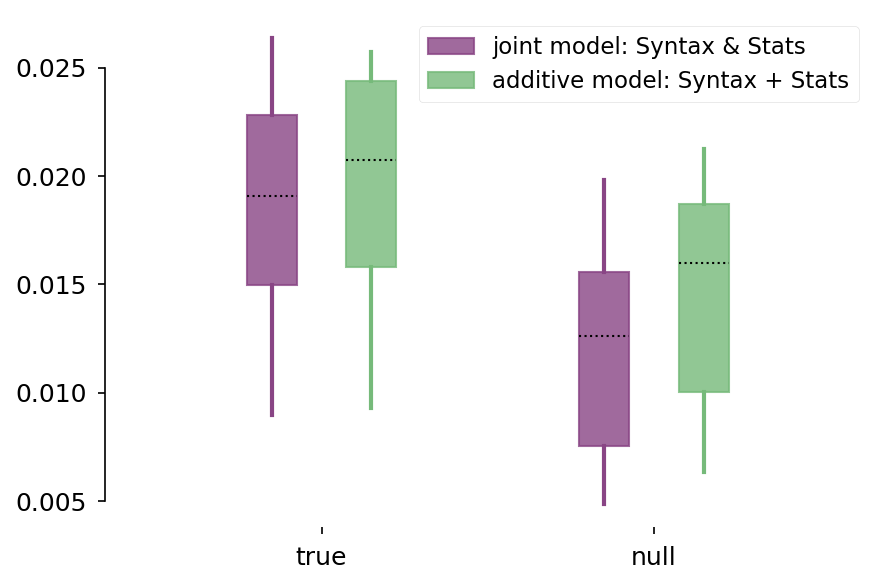

In [197]:
with plt.style.context(['seaborn-paper', {'xtick.labelsize':12, 'ytick.labelsize':12, 'legend.fontsize':11, 'pdf.fonttype': 42}]):
    plt.figure(figsize=(6, 4), dpi=150)
    c1, c2 = 'xkcd:light eggplant', reverse_color('xkcd:light eggplant')
    boxplot_kwargs = dict(patch_artist=True, medianprops={'color':'k', 'ls':':'}, showcaps=False)
    b1 = plt.boxplot([all_scores, all_scores_null], positions=[1-0.15, 2-0.15], boxprops={'facecolor':c1, 'alpha':0.8, 'edgecolor':c1}, whiskerprops={'lw':2, 'color':c1}, **boxplot_kwargs)
    b2 = plt.boxplot([add_scores, add_scores_null], positions=[1+0.15, 2+0.15], boxprops={'facecolor':c2, 'alpha':0.8, 'edgecolor':c2}, whiskerprops={'lw':2, 'color':c2}, **boxplot_kwargs)
    plt.xticks(ticks=[1, 2], labels=['true', 'null'])
    plt.legend([b1['boxes'][0], b2['boxes'][0]], ['joint model: Syntax & Stats', 'additive model: Syntax + Stats'])
    sns.despine(trim=True, bottom=True)
    plt.tight_layout()
    plt.savefig('Results/JointVSAdditive_otherSubj.pdf')

## Main loop over all subjects

In [2]:
import pandas as pd
featsets = [['wordonsets'],
         ['wordonsets', 'entropy', 'surprisal'],
         ['wordonsets', 'depth', 'close'],
         ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']]
feat_ids = {v:k for k,v in zip(range(5), ['wordonsets', 'entropy', 'surprisal', 'depth', 'close'])}

In [235]:
tmin, tmax = -0.2, 0.7
trf = TRFEstimator(tmin=tmin, tmax=tmax, srate=fs, alpha=1e-5, verbose=False) # 1e4 for orignal envwhich_score, maybe a bit less for derivative?

use_icaed = True
show_individual_plots = True

# Can tune to a specific frequency, then apply hilbert to get power or 'ITC' (after normalise complex) -> abs to be taken on coef later!!
filter_range = (0.5, 4.5)
apply_hilbert = True
extract_power = False
normalize_to_unit = True

scores = pd.DataFrame(columns=['score_rel', 'score', 'score_null', 'feats', 'subj'])
for ksub, subject in enumerate(SUBJECTS):

    print(f"Loading Raws for subject {subject}")
    try:
        raws = extract_story_parts_data(subject, ica=use_icaed, filter=filter_range)
        if fs!=raws[0].info['sfreq']:
            print("Resampling...")
            for k, r in tqdm(enumerate(raws), total=len(raws)):
                raws[k] = r.resample(fs, n_jobs=-2)
        
        info = raws[0].info
        picks = mne.pick_types(info, meg=True, ref_meg=False, exclude=bads)
        lengths = [min(len(r), len(x)) for r,x in zip(raws, X)]
        for r in raws: r.pick(picks)
        # NEw code to score all PAC , band specifics power and itcs models
        if apply_hilbert:
            for k, r in tqdm(enumerate(raws), total=len(raws), desc='Hilbert and normalize'):
                raws[k] = r.apply_hilbert(envelope=extract_power)
                if normalize_to_unit:
                    raws[k] = raws[k].apply_function(normalise_complex)        
        
    except:
        print(f"Error in loading/computation for {subject}. Skipping.")
        continue

    for feats in featsets:
        print("Scoring for : ", feats)
        scores_oneout = []
        scores_null = []
        for kstory, x,r,length in zip(range(len(X)), X, raws, lengths):
            # Fit true model
            trf.fit([xx[:l][:, [feat_ids[f] for f in feats]] for k, (xx, l) in enumerate(zip(X, lengths)) if k != kstory],
                    [rr.get_data().T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
            scores_oneout.append(trf.score(x[:length][:, [feat_ids[f] for f in feats]], r.get_data().T[:length], reduce_multi='mean'))
            # Fit and score NULL MODEL
            trf.fit([xx[:l][:, [feat_ids[f] for f in feats]] for k, (xx, l) in enumerate(zip(Xnoise, lengths)) if k != kstory],
                    [rr.get_data().T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
            scores_null.append(trf.score(x[:length][:, [feat_ids[f] for f in feats]], r.get_data().T[:length], reduce_multi='mean'))
        tmp = pd.DataFrame(columns=['score_rel', 'score', 'score_null', 'feats', 'subj'])
        tmp.score_rel = [np.mean(scores_oneout)-np.mean(scores_null)] # store increment beyond null model
        tmp.score_null = [np.mean(scores_null)]
        tmp.score = [np.mean(scores_oneout)] 
        tmp.feats = ['_'.join([f[0] for f in feats])]
        tmp.subj = [subject]
        scores = pd.concat([scores, tmp], ignore_index=True)

Loading Raws for subject sub-003
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-004
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-002
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-001
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-030
Error in loading or cacho computation for sub-030. Skipping.
Loading Raws for subject sub-008
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-006
Error in loading or cacho computation for sub-006. Skipping.
Loading Raws for subject sub-009
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-010
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-011
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-013
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-024
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-018
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-019
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-005
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-020
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-021
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-023
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-027
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-014
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-025
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-026
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-015
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-028
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-029
Resampling...


  0%|          | 0/13 [00:00<?, ?it/s]

Hilbert and normalize:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring for :  ['wordonsets']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Scoring for :  ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading Raws for subject sub-032
Error in loading or cacho computation for sub-032. Skipping.
Loading Raws for subject sub-033
Error in loading or cacho computation for sub-033. Skipping.
Loading Raws for subject sub-007
Error in loading or cacho computation for sub-007. Skipping.
Loading Raws for subject sub-017
Error in loading or cacho computation for sub-017. Skipping.
Loading Raws for subject sub-034
Error in loading or cacho computation for sub-034. Skipping.


In [236]:
from scipy.stats import ttest_rel
from pyeeg.vizu import significance_overlay

In [237]:
scores['score_prct'] = scores.score_rel/scores.score_null *100

(array([31., 23., 15., 15.,  4.,  1.,  0.,  1.,  0.,  2.]),
 array([0.0, 4.9282339379077, 9.8564678758154, 14.7847018137231,
        19.7129357516308, 24.641169689538497, 29.5694036274462,
        34.4976375653539, 39.4258715032616, 44.354105441169295,
        49.282339379076994], dtype=object),
 <BarContainer object of 10 artists>)

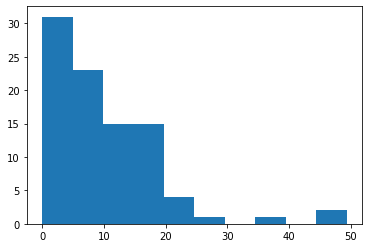

In [249]:
plt.hist(scores.filter(like='scor').apply(np.abs, axis=0).score_prct)

In [240]:
which_score = 'score'
ttest_rel(scores.loc[scores.feats=='w_e_s', which_score], scores.loc[scores.feats=='w_d_c', which_score]).pvalue*2*3

TypeError: can't convert complex to float

In [254]:
scores.loc[scores.feats=='w_e_s', which_score].values

array([(0.06198093706113377+0.00012558122418309384j),
       (0.08169601747591783-0.00020409017898371666j),
       (0.03667480220602987+0.0005088939079327801j),
       (0.084283281551545-0.0012149417263528685j),
       (0.08958727756922209-0.00017730671728423986j),
       (0.07566708659026304+0.00022746558902478535j),
       (0.06764457120200822-0.00020972034747389652j),
       (0.07144564572042282+0.0009996224850080961j),
       (0.0674132642209327+7.09174577613063e-06j),
       (0.07939419241028021+0.00040366706273557105j),
       (0.05914573742004435-6.734206814176165e-05j),
       (0.0654363005846276-0.0001264392214690522j),
       (0.05282403834553121+0.00016613619652699574j),
       (0.054579186796768264+0.0007259623703537508j),
       (0.12263625506144835+7.803825451585186e-05j),
       (0.08046238762770894+0.000147441904929092j),
       (0.08132810457918777+0.0001965378999905359j),
       (0.09646801176639751+0.0002900703455417953j),
       (0.09621856821983453-0.00052168099487

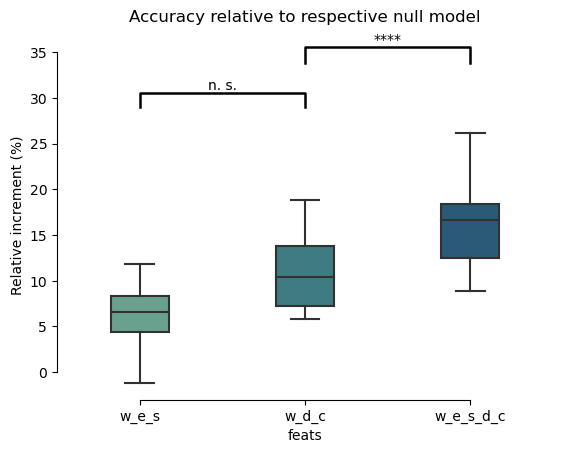

In [158]:
with plt.style.context("default"):
    which_score = 'score_prct'
    sns.boxplot(data=scores, x='feats', y=which_score, showfliers=False, order=['w_e_s', 'w_d_c', 'w_e_s_d_c'], width=0.35, palette='crest')
    significance_overlay(ttest_rel(scores.loc[scores.feats=='w_e_s', which_score], scores.loc[scores.feats=='w_d_c', which_score]).pvalue*2, [0, 1], maxasterix=3)
    #significance_overlay(ttest_rel(scores.loc[scores.feats=='w_e_s', which_score], scores.loc[scores.feats=='w', which_score]).pvalue*3, [0, 1], maxasterix=4)
    significance_overlay(ttest_rel(scores.loc[scores.feats=='w_e_s_d_c', which_score], scores.loc[scores.feats=='w_d_c', which_score]).pvalue*2, [1, 2], maxasterix=4)
    plt.ylabel("Relative increment (%)")
    plt.title("Accuracy relative to respective null model")
    sns.despine(trim=True)

# plt.savefig("rough_comparison_scores_relat_to_null.png")
# plt.savefig("rough_comparison_scores_relat_to_null.eps")
plt.savefig("rough_comparison_scores_pct_to_null.pdf")

# Phase amplitude coupling - compute

## Utils

In [207]:
from audiobook.utils import extract_resting_states
from mne import compute_covariance
import mne
import pandas as pd
from audiobook.features import generate_wordlevel_feats

def get_meg_xfreq_data(subject, fs=50, low=(0.5, 4.5), high=(15, 30), use_icaed=False, resting_state=False):
    """
    Will load data as "r(t) * exp(1j*theta(t))"
    Where r(t) is the amplitude of high frequency band power,
    and theta(t) is the phase in the slow osc.
    """
#     print("Extracting raw data...")
    if resting_state:
        raws = extract_resting_states(subject, ica=use_icaed, filter=None)
        raws.load_data()
        raws.pick_types(meg=True, ref_meg=False, exclude=bads)
        beta = raws.copy().filter(*high).apply_hilbert(envelope=True)
        if fs!=beta.info['sfreq']:
            beta = beta.resample(fs, n_jobs=1)
            delta = raws.copy().resample(fs, n_jobs=1).filter(*low).apply_hilbert()
        else:
            delta = raws.copy().filter(*low).apply_hilbert(envelope=False, picks=picks)
        beta._data = beta._data * delta._data / np.abs(delta._data)
        return beta
    else:
        raws =  extract_story_parts_data(subject, ica=False, filter=None)[:9] # only dutch for now...
        info = raws[0].info
        picks = mne.pick_types(info, meg=True, ref_meg=False, exclude=bads)
    #     print("Computing filtered analytical signals and creating compound r*exp(i*theta)...")
        out = []
        for r in raws:
            raw = r.copy()
            # Pick channels straight away
            raw.pick_types(meg=True, ref_meg=False, exclude=bads)
            beta = raw.copy().filter(*high).apply_hilbert(envelope=True)
            if fs!=info['sfreq']:
                beta = beta.resample(fs, n_jobs=-2)
                delta = raw.copy().resample(fs, n_jobs=-2).filter(*low).apply_hilbert()
            else:
                delta = raw.copy().filter(*low).apply_hilbert(envelope=False, picks=picks)
            out.append(beta.copy())
            # Both ways giuve numerically similar answer but the first (complex normalisation) way is 10x faster
            out[-1]._data = beta._data * delta._data / np.abs(delta._data)
            # Alternative way
            #out[-1]._data = beta._data * np.exp(1j*np.angle(delta._data))
        return out

def get_feature_matrix(raws, feats=None, normalise='all'):
    X = []
    if feats is None: # use all
        feats = slice(9)
    for s, r in zip(STORIES.filename[:9], raws): # only dutch for now
        X.append(generate_wordlevel_feats(s, srate=r.info['sfreq'], N=r.n_times)[:, feats])
    var = np.var(np.vstack(X), 0)
    for x in X:
        if normalise=='all':
            x /= var
        else:
            x /= np.var(x, 0)
            
    return X

In [5]:
dark_blood = sns.dark_palette([0.58, 0.18, 0.28], as_cmap=True)

In [52]:
X = get_feature_signal(feats=['wordonsets', 'entropy', 'surprisal', 'depth', 'close'], stories=STORIES.filename.str.strip('.wav')[:9], srate=100)
# TODO: test if the way of getting the stim data below is EQUIVALENT!!
#X = get_feature_matrix(raws, feats=[0, 2, 1, 7, 8])

Load stimulus features
Loading feature signal for : ['wordonsets', 'entropy', 'surprisal', 'depth', 'close']
Done. X shape: (29800, 5)


In [54]:
# null stims
Xnoise = []
for k, x in enumerate(X):
    xn = x.copy()
    nonz = np.argwhere(xn[:, 0]) # non zero entries
    vals = xn[nonz] # only values
    xn[nonz] = np.roll(vals, -12, axis=0) #roll 12 words backwards
    Xnoise.append(xn)

In [6]:
import os
from functools import reduce

from scipy.stats import ttest_rel, ttest_1samp
from scipy.signal import find_peaks
from colorama import Fore
from statsmodels.stats.multitest import fdrcorrection

from mne.time_frequency import tfr_array_morlet, tfr_array_multitaper, tfr_morlet, tfr_multitaper

from scipy.stats import distributions
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [206]:
def normalise_complex(c):
    return c/np.abs(c)

freqbands = {'delta': [.4, 4.5],
            'theta': [4., 8.],
            'alpha': [8., 12.],
            'beta':[15, 26.],
            'gamma':[35, 70.]}

In [8]:
raws = extract_story_parts_data(SUBJECTS[3], ica=True, filter=None)
info = raws[0].info
picks = mne.pick_types(info, meg=True, ref_meg=False, exclude=bads)

In [53]:
events = mne.find_events(mne.io.RawArray(X[0][:, [0]].T, mne.create_info(['STI_014'], 100, ch_types='stim')))
events[:, 0] *= 200//100 #  upsample event timings
events[:, 0] += raws[0].first_samp

Creating RawArray with float64 data, n_channels=1, n_times=29800
    Range : 0 ... 29799 =      0.000 ...   297.990 secs
Ready.
938 events found
Event IDs: [5]


In [9]:
info = mne.pick_info(info, sel=picks)

Removing 5 compensators from info because not all compensation channels were picked.


In [10]:
adj, ch = mne.channels.find_ch_adjacency(info, 'mag')
adj = adj[[ch.index(c) for c in ch if c in info.ch_names]][:, [ch.index(c) for c in ch if c in info.ch_names]]

Reading adjacency matrix for ctf275.


### Testing ground

I am now trying Wavelet transform to get the STRF output instead of band specific.

In [13]:
from pyeeg.preprocess import WaveletTransform
from pyeeg.vizu import plot_filterbank_output

In [14]:
fmin, fmax = 5, 70
nfreqs = 16
freqs = np.logspace(np.log10(fmin), np.log10(fmax), nfreqs)
cycles = np.linspace(5, 15, nfreqs)

In [111]:
tf_data = []
for r in tqdm(raws[:9], desc='Story processing: '):
    # High pass filter data
    r = r.filter(4, None)
    # Time-frequency reprentation;
    out = WaveletTransform(freqs, r.info['sfreq'], cycles).transform(r._data[picks].T)
    # Low pass (20Hz) filter result and resample
    out = mne.filter.filter_data(np.abs(out).astype(float).swapaxes(1, 2), r.info['sfreq'], None, 20, verbose=False)
    tf_data.append(mne.filter.resample(out, down=4, npad='auto', axis=-1))

In [118]:
# Computing STRF
lengths = [min(len(x),r.shape[-1]) for x,r in zip(X,tf_data)]
spectral_trfs = []
for c in tqdm(range(nfreqs), desc='STRF channel: '):
    trf = TRFEstimator(tmin=-0.2, tmax=0.6, srate=50)
    trf.fit([x[:l, [0]] for x,l in zip(X[:9], lengths)], [t[c].T[:l] for t,l in zip(tf_data, lengths)], drop=False)
    spectral_trfs.append(trf)

STRF channel:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

#### Single subject STRF

Loaded from files

In [15]:
loader = np.load('Data/TRF_All_kinds/sub-004_strf.npz', allow_pickle=True)
strf, times, freqs = loader['strf'], loader['times'], loader['freqs']

In [17]:
tfr = mne.time_frequency.AverageTFR(info, strf.squeeze().transpose(2, 0, 1), times, freqs, 9)

No baseline correction applied


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


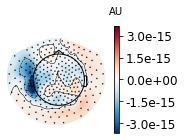

Applying baseline correction (mode: mean)


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


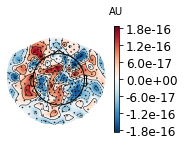

In [31]:
tfr.plot_topomap(tmin=0.3, tmax=0.45, fmin=8, fmax=12, sphere=0.1);
tfr.plot_topomap(baseline=(None, -0.05), tmin=0., tmax=0.1, fmin=30, fmax=80, sphere=0.1);

[Text(0, 4, '4'),
 Text(0, 7, '7'),
 Text(0, 12, '12'),
 Text(0, 23, '23'),
 Text(0, 41, '41'),
 Text(0, 75, '75')]

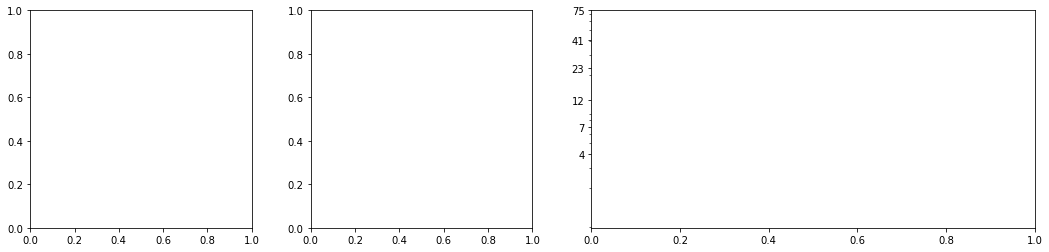

In [38]:
# Simply testing how to set the y-ticks correctly
f, ax = plt.subplots(1, 3, figsize=(18, 4), gridspec_kw={'width_ratios':[1,1,2]})
ax[-1].set_yscale("log")
ax[-1].set_yticks(np.logspace(np.log10(4), np.log10(75), 16)[::3].astype(int))
ax[-1].set_yticklabels(np.logspace(np.log10(4), np.log10(75), 16)[::3].astype(int))

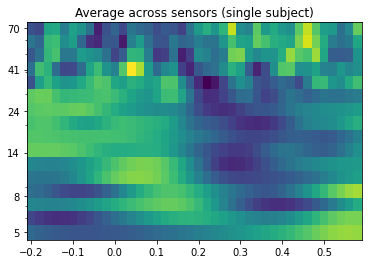

In [37]:
f = plt.figure()
ax = f.add_subplot()
plt.yscale('log')
ax.set_yticks(freqs[::3].astype(int))
ax.set_yticklabels(freqs[::3].astype(int))
ax.pcolormesh(times, freqs, zscore(strf.mean(-1)[..., 0], axis=1), shading='auto');
plt.title("Average across sensors (single subject)");

#### Across subjects STRFs

Loaded from files.

In [11]:
import glob

In [12]:
strf_files = glob.glob('Data/TRF_All_kinds/*strf*')
strfs = []
for f in strf_files:
    loader = np.load(f, allow_pickle=True)
    strf, times, freqs = loader['strf'], loader['times'], loader['freqs']
    if strf.shape[-1] != 267: continue
    strfs.append(strf)

In [13]:
# Grand average
strf = np.mean(np.stack(strfs), 0)

In [134]:
bl.shape

(16, 1, 1, 267)

In [133]:
np.max(bl, axis=1).shape

(16, 1, 267)

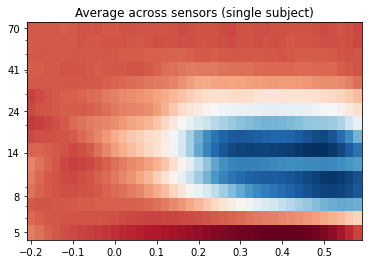

In [143]:
f = plt.figure()
ax = f.add_subplot()
plt.yscale('log')
ax.set_yticks(freqs[::3].astype(int))
ax.set_yticklabels(freqs[::3].astype(int))
ax.pcolormesh(times, freqs, ((strf - bl)).mean(-1)[..., 0], shading='auto', cmap='RdBu_r');
plt.title("Average across sensors (grand average)");

In [129]:
(strf - bl).mean(-1).squeeze()[:, times < 0.].mean(-1)

array([ 8.35470253e-18,  1.69482606e-18, -1.90474609e-18, -1.40017599e-18,
       -3.44922715e-18, -5.26615473e-19, -8.95423715e-18, -1.45410694e-17,
       -1.11515783e-17, -4.17805429e-18, -6.90184067e-18, -1.07784858e-18,
       -3.93744547e-19, -1.98016426e-19,  7.88021841e-19,  9.42332388e-19])

In [141]:
bl = strf[:, times < -0.05, ...].mean(1, keepdims=True)
sig = strf[:, times < 0., ...].max(1, keepdims=True)

In [15]:
# baseline removal
strf.squeeze()

(16, 40, 1, 267)

In [145]:
full_adj = mne.stats.combine_adjacency(len(times), np.zeros((len(freqs), len(freqs))), adj) # by doing this I force "no neighborhood" in the frequency domain

In [147]:
data = np.stack(strfs).squeeze().transpose(0, 2, 1, 3)

In [148]:
# Stats
cluster_stats = mne.stats.cluster_level.permutation_cluster_1samp_test(data, adjacency=full_adj)

Using a threshold of 2.063899
stat_fun(H1): min=-8.599426 max=5.351672
Running initial clustering
Found 860 clusters
Permuting 1023 times...


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          |  : 0/1023 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [171]:
data.shape

(25, 40, 16, 267)

/data/hugwei/47423841.dccn-l029.dccn.nl/ipykernel_9627/1244727397.py:6: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(to_plot, axis=-1).T, aspect='auto', cmap='plasma', origin='lower')


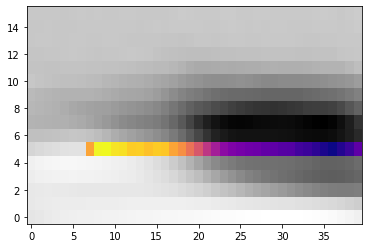

In [195]:
cl = 7
to_plot = data.mean(0)
plt.imshow(to_plot.mean(-1).T, aspect='auto', cmap='Greys_r', origin='lower')
to_plot = np.ones_like(data.mean(0)) * np.nan
to_plot[cluster_stats[1][clust_idx[cl]]] = data.mean(0)[cluster_stats[1][clust_idx[cl]]]
plt.imshow(np.nanmean(to_plot, axis=-1).T, aspect='auto', cmap='plasma', origin='lower')

In [156]:
clust_idx = np.where(cluster_stats[2] < 0.05)[0] # 8 clusters!!!
clus = cluster_stats[1]

for cidx in clust_idx:
    tsigni, fsigni, chansigni = clus[cidx]

#### Scanning frequencies for PAC at word onset

- We can do it from TEmpRespFunc
- or from direct complex TimeFreqRepr with morlet wavelet (via MNE, or by hand)

Once I have amplitude and phase for a lot of frequencies I can compute mean vector length for each pair.

Actually I only need amplitude for 8- 60 Hz
And Phase for 1 - 12 Hz let's say. 
**So I'll need to compute a TFR twice**??

In [11]:
### Testing with Time Freq complex representation from wavelet directlt, then let's compose a per channel Mean-vector_length PAC for every freqs

In [11]:
from audiobook.text import get_wordlevel_aligned

In [195]:
get_wordlevel_aligned(storyname=STORIES.filename[0].split('_normalized.wav')[0], annot='stan')

Aligning dataframes...

100%|██████████| 939/939 [00:03<00:00, 299.65it/s]


word   onset  offset    id     token     lemma   upos  \
0         het    0.41    0.49   1.0       het       het   PRON   
1         was    0.49    0.63   2.0       was      zijn    AUX   
2    heerlijk    0.70    1.02   3.0  heerlijk  heerlijk    ADJ   
3      buiten    1.02    1.34   4.0    buiten    buiten    ADP   
4          op    1.34    1.45   5.0        op        op    ADP   
..        ...     ...     ...   ...       ...       ...    ...   
934        en  296.16  296.26  34.0        en        en  CCONJ   
935  menschen  296.26  296.67  35.0  menschen    mensch   NOUN   
936    erkend  296.75  297.12  36.0    erkend  erkennen   VERB   
937      moet  297.12  297.28  37.0      moet    moeten    AUX   
938    worden  297.28  297.52  38.0    worden    worden    AUX   

                                xpos                                feats  \
0    VNW|pers|pron|stan|red|3|ev|onz                Person=3|PronType=Prs   
1                      WW|pv|verl|ev  Number=Sing|Tense=Past|VerbForm=Fin   
2              ADJ|vrij|basis|zonder                           Degree=Pos   
3                             VZ|fin                                  NaN   
4                            VZ|init                                  NaN   
..                               ...                                  ...   
934                         VG|neven                                  NaN   
935                 N|soort|mv|basis                          Number=Plur   
936                WW|vd|vrij|zonder                        VerbForm=Part   
937                     WW|pv|tgw|ev  Number=Sing|Tense=Pres|VerbForm=Fin   
938               WW|inf|vrij|zonder                         VerbForm=Inf   

     head    deprel  start_char  end_char ner  
0     3.0     nsubj         0.0       3.0   O  
1     3.0       cop         4.0       7.0   O  
2     0.0      root         8.0      16.0   O  
3     3.0       obl        17.0      23.0   O  
4     7.0      case        24.0      26.0   O  
..    ...       ...         ...       ...  ..  
934  35.0        cc      4972.0    4974.0   O  
935  33.0      conj      4975.0    4983.0   O  
936  27.0      conj      4984.0    4990.0   O  
937  36.0       aux      4991.0    4995.0   O  
938  36.0  aux:pass      4996.0    5002.0   O  

[939 rows x 14 columns]

In [79]:
epochs = mne.Epochs(raws[0], events, event_id={'Word onset':events[0, -1]}, tmin=-0.4, tmax=0.8, picks=picks, flat=None) # here only one story

Not setting metadata
Not setting metadata
938 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
Setting baseline interval to [-0.4, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [87]:
# 500Mb per epoch data
# 9 dutch stories -> ~5Gb for entire data to pass to time freq computation

# Then time freq for power is roughly 7Gb (need 10 for computation?)
# For phase it will be double! so 14 Gb PER STORY!!!

In [88]:
nfreqs = 16
freqs_amp = np.linspace(8., 80., nfreqs)
freqs_phase = np.linspace(1.5, 12., nfreqs)
cycles = np.linspace(2, 17, nfreqs) # between 0.2125 and 0.25 ms resolution for amplitudes
                                    # by halving the cycles for phase it's around 0.6sec wavelet length

In [115]:
timefreq = tfr_morlet(epochs, freqs_amp, cycles, use_fft=False, output='power', average=False, return_itc=False) # a quick and dirty tfr

Not setting metadata


In [93]:
# Same for phase
timefreq_phases = tfr_morlet(epochs, freqs_phase, cycles/2., use_fft=True, output='complex', average=False, return_itc=False) # a quick and dirty tfr

Not setting metadata


In [102]:
timefreq.apply_baseline(baseline=(None, 0), mode='logratio')

Applying baseline correction (mode: logratio)


<EpochsTFR | time : [-0.400000, 0.800000], freq : [8.000000, 80.000000], epochs : 937, channels : 267, ~7.19 GB>

In [95]:
avg_itc = timefreq_phases.average(method=lambda s: np.abs(normalise_complex(s).mean(0))) # mean over normalised phasors

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/

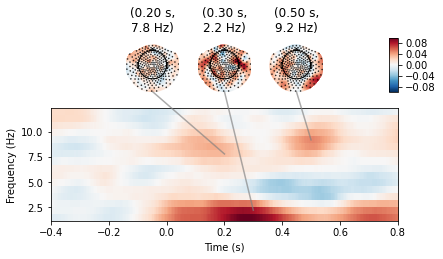

In [96]:
avg_itc.plot_joint(timefreqs=((0.2, 7.5), (0.3, 2), (0.5, 9)), baseline=(None, 0), topomap_args=dict(sphere=0.1, contours=0));

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/baseline.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: d

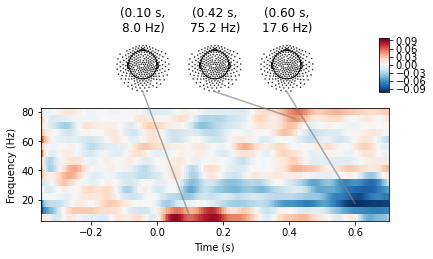

In [123]:
timefreq.average().crop(tmin=-0.35, tmax=0.7).plot_joint(timefreqs=((0.1, 10), (0.6, 18), (0.42, 75)), baseline=(None, 0), mode='logratio', topomap_args=dict(sphere=0.1));

In [157]:
from itertools import product

In [158]:
freq_slow = freqs_phase
freq_fast = freqs_amp

In [159]:
%%time
pac = np.zeros((len(freq_slow), len(freq_fast), 267, len(timefreq.times)))
for (f1, f2), (k1, k2) in tqdm(zip(product(freq_slow, freq_fast), product(range(len(freq_slow)), range(len(freq_fast)))), total=len(freq_slow)*len(freq_fast)):
    phase_bin = np.argmin(abs(timefreq_phases.freqs - f1))
    amp_bin = np.argmin(abs(timefreq.freqs - f2))
    phase = normalise_complex(timefreq_phases.data[:, :, phase_bin, :])
    amp = timefreq.data[:, :, amp_bin, :]
    # With baseline-ing
    #pac[k1, k2] = np.abs((amp * phase).mean(0)/amp.mean(-1, keepdims=True).mean(0, keepdims=True)
    # Without baseline)
    pac[k1, k2] = np.abs((amp * phase).mean(0))

  0%|          | 0/256 [00:00<?, ?it/s]

CPU times: user 8min 39s, sys: 1min 59s, total: 10min 39s
Wall time: 11min 5s


Text(0.5, 1.0, 'Normalising by average power')

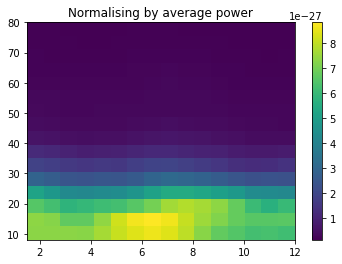

In [180]:
im = plt.imshow(pac.mean(-1)[..., 10:20].mean(-1).T, origin='lower', extent=[freq_slow[0],freq_slow[-1],freq_fast[0],freq_fast[-1]], aspect='auto')
plt.colorbar(im)
plt.title("Normalising by average power")

In [191]:
regions = mne.channels._divide_to_regions(info, add_stim=False)

Text(0.5, 0.98, 'PAC (log ratio with baseline)')

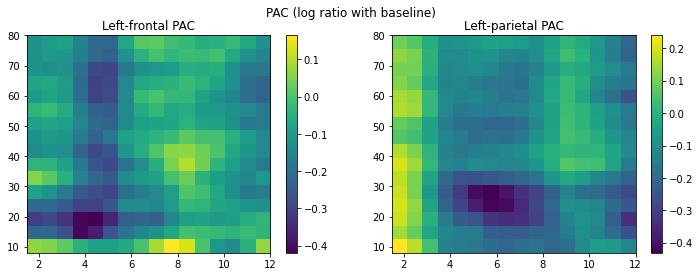

In [197]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
im = ax[0].imshow(np.log(pac/pac[..., timefreq.times<0].mean(-1, keepdims=True)).mean(-1)[..., regions['Left-frontal']].mean(-1).T, origin='lower', extent=[freq_slow[0],freq_slow[-1],freq_fast[0],freq_fast[-1]], aspect='auto')
plt.colorbar(im, ax=ax[0])
ax[0].set_title("Left-frontal PAC")
im = ax[1].imshow(np.log(pac/pac[..., timefreq.times<0].mean(-1, keepdims=True)).mean(-1)[..., regions['Left-parietal']].mean(-1).T, origin='lower', extent=[freq_slow[0],freq_slow[-1],freq_fast[0],freq_fast[-1]], aspect='auto')
plt.colorbar(im, ax=ax[1])
ax[1].set_title("Left-parietal PAC")
f.suptitle("PAC (log ratio with baseline)")

/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


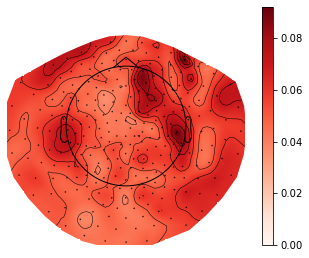

In [170]:
low_f = freqbands['delta']
fast_f = freqbands['beta']
def search_idx(arr, val): return np.argmin(np.abs(arr - val))

topomap(pac[search_idx(freqs_phase, low_f[0]):search_idx(freqs_phase, low_f[1]),
            search_idx(freqs_amp, fast_f[0]):search_idx(freqs_amp, fast_f[1]), ...].mean(0).mean(0).mean(-1), info);

/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Text(0.5, 1.0, 'No normalisation')

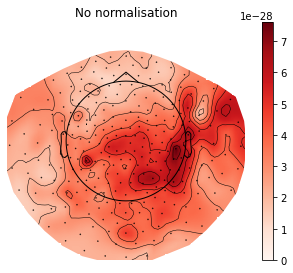

In [181]:
low_f = freqbands['theta']
fast_f = freqbands['gamma']
def search_idx(arr, val): return np.argmin(np.abs(arr - val))

topomap(pac[search_idx(freqs_phase, low_f[0]):search_idx(freqs_phase, low_f[1]),
            search_idx(freqs_amp, fast_f[0]):search_idx(freqs_amp, fast_f[1]), ...].mean(0).mean(0).mean(-1), info);
plt.title("No normalisation")

### Plot Phase and power desciptives

In [212]:
all_trfs = []
analysis_name = 'gamma_power' # delta_ITC, theta_ITC, gamma_power, beta_power
files = [f for f in os.listdir('Data/TRF_All_kinds/') if analysis_name in f]

# Load data if exists on disk
if len(files) > 0:
    for f in tqdm(files, desc='Loading TRF files...'):
        all_trfs.append(TRFEstimator.load(os.path.join('Data/TRF_All_kinds/', f)))
    trf = all_trfs[-1]
        
# Else run TRF computation
else:
    for subject in tqdm(SUBJECTS, desc='Outer subject (main) loop: '):
        try:
            raws = extract_story_parts_data(subject, ica=True, filter=None)
            info = raws[0].info
            picks = mne.pick_types(info, meg=True, ref_meg=False, exclude=bads)
            if len(picks) != 267:
                raise ValueError(f"Not the same number of channel for subject {subject}! (Got {len(picks)} channels, instead of 267)")
        except (ValueError, FileNotFoundError) as e:
            print(e)
            continue
        for r in tqdm(raws, desc='Extracting phase or power and resampling: ', leave=False):
            # ITC (resample first, cause we are in low frequencies) then filter and take the angle
            if 'itc' in analysis_name.lower():
                r.resample(50)
                r = r.filter(*freqbands[analysis_name.split('_')[0]]).apply_hilbert(envelope=False).apply_function(normalise_complex, channel_wise=False)
            # But for Power, simply take the amplitude of hilbert and resample afterwards
            else:
                r = r.filter(*freqbands[analysis_name.split('_')[0]]).apply_hilbert(envelope=True)
                r.resample(50)

        lengths = [min(len(x),len(r)) for x,r in zip(X,raws)]
        trf = TRFEstimator(tmin=-0.2, tmax=0.6, srate=50)
        trf.fit([x[:l, [0]] for x,l in zip(X, lengths)], [r._data.T[:l, picks] for r, l in zip(raws, lengths)], drop=False);
        all_trfs.append(trf)
        
    # Save on disk
    for k, t in enumerate(all_trfs):
        t.save(f"Data/TRF_All_kinds/{analysis_name}_sub{k}.npz")

Loading TRF files...:   0%|          | 0/25 [00:00<?, ?it/s]

In [197]:
baseline = np.argwhere(trf.times < 0.)
threshold = distributions.t.isf(0.00005, df=len(all_trfs))

if 'itc' in analysis_name.lower():
    stats = mne.stats.cluster_level.spatio_temporal_cluster_1samp_test(
        np.stack([abs(t.coef_[:, 0, :]) - abs(t.coef_[baseline, 0, :]).mean(0) for t in all_trfs]).squeeze(),
        adjacency=adj, tail=1, threshold=threshold
    )
else:
    stats = mne.stats.cluster_level.spatio_temporal_cluster_1samp_test(
        np.stack([t.coef_[:, 0, :] - t.coef_[baseline, 0, :].mean(0) for t in all_trfs]).squeeze(),
        adjacency=adj, threshold=threshold
    )
tstat, clus, pvals, _ = stats

stat_fun(H1): min=-8.432051 max=3.890109
Running initial clustering
Found 23 clusters
Permuting 1023 times...


  0%|          |  : 0/1023 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [215]:
clus_number = 0

/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


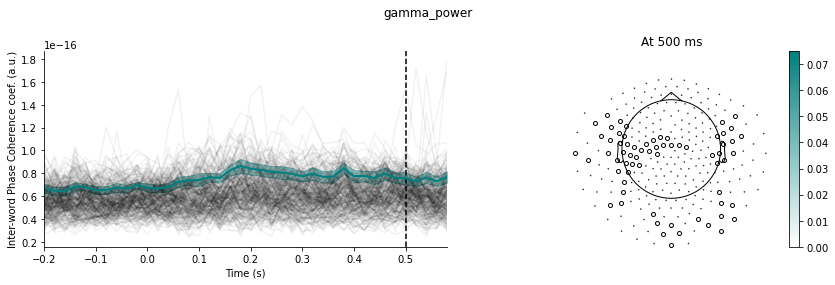

In [221]:
# Figure showing ITPC in theta or delta (grand average), TRF and topography at peak

# Find peak time
gfp = np.var(reduce(lambda x,y: x+y, all_trfs).coef_[:, 0, :], axis=-1)
half_height = max(gfp)/2
peak_idx, props = find_peaks(gfp, height=half_height)
# Clean up: take top peak
if len(peak_idx) > 1:
    peak_idx = peak_idx[np.argmax(props['peak_heights'])]
else:
    peak_idx = peak_idx[0]
    
# Get 75% top channels
tspan, _ = clus[np.argmin(pvals)]
grd_avg = reduce(lambda x,y: x+y, [t.apply_func(np.abs) for t in all_trfs]).coef_[:, 0, :]/len(all_trfs)
chan_sel = grd_avg[min(tspan):max(tspan), :].mean(0) > np.percentile(grd_avg[min(tspan):max(tspan), :].mean(0), 75.)
cluster = grd_avg[:, chan_sel].mean(1)
sem = np.std(np.stack([t.apply_func(np.abs).coef_[:, 0, chan_sel].mean(1) for t in all_trfs]), 0)/np.sqrt(len(all_trfs))

# Plot
tone = 'teal'
f, ax = plt.subplots(1, 2, figsize=(12, 4))
crimson_cm = LinearSegmentedColormap.from_list('test', ['w', tone])

# Time course
reduce(lambda x,y: x+y, [t.apply_func(lambda x: np.abs(x)/len(all_trfs)) for t in all_trfs]).plot(ax=ax[0]);
lines = ax[0].get_lines()
for l in lines:
    l.set_color('k')
    l.set_alpha(0.05)
ax[0].axvline(trf.times[peak_idx], color='k', ls='--')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Inter-word Phase Coherence coef. (a.u.)")
ax[0].plot(trf.times, cluster, color=tone, lw=2)
ax[0].fill_between(trf.times, cluster+sem, cluster-sem, alpha=0.4, color=tone)

# Topomap
topomap(reduce(lambda x,y: x+y, [t.apply_func(np.abs) for t in all_trfs]).coef_[abs(trf.times - trf.times[peak_idx]).argmin(), 0, :],
        info, ax=ax[1], contours=0, cmap=crimson_cm, vmin=0.075, mask=chan_sel);
ax[1].set_title(f"At {trf.times[peak_idx]*1e3:.0f} ms")

# Tidy up
sns.despine(ax=ax[0])
ax[0].set_xmargin(0)
f.suptitle(analysis_name);
f.tight_layout()
plt.subplots_adjust(wspace=0)

# Save figure
f.savefig('Results/PAC/sanity_check_' + analysis_name + '3.pdf', dpi=150)

/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


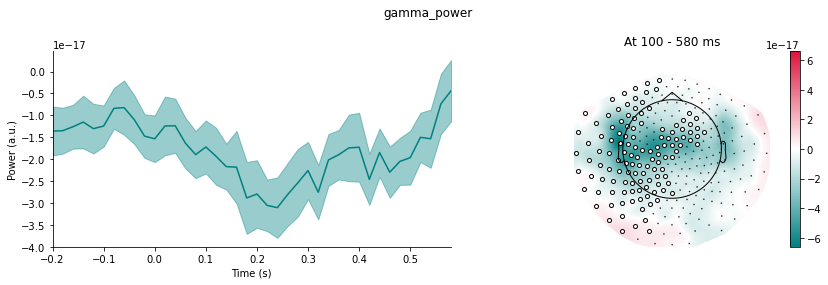

In [223]:
# Figure showing ITPC in theta or delta (grand average), TRF and topography at peak

# Find peak time
gfp = np.var(reduce(lambda x,y: x+y, all_trfs).coef_[:, 0, :], axis=-1)
half_height = max(gfp)/2
peak_idx, props = find_peaks(gfp, height=half_height)
# Clean up: take top peak
if len(peak_idx) > 1:
    peak_idx = peak_idx[np.argmax(props['peak_heights'])]
else:
    peak_idx = peak_idx[0]
    
# Get top cluster
idx_topcluster = np.argmin(pvals)
tspan, chans = clus[idx_topcluster]
grd_avg = reduce(lambda x,y: x+y, all_trfs).coef_[:, 0, :]/len(all_trfs)
cluster = grd_avg[:, np.unique(chans)].mean(1)
sem = np.std(np.stack([t.coef_[:, 0, np.unique(chans)].mean(1) for t in all_trfs]), 0)/np.sqrt(len(all_trfs))

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 4))
tone = 'teal'
crimson_cm = LinearSegmentedColormap.from_list('test', [tone, 'w', 'crimson'])

t1, t2 = trf.times[min(tspan)], trf.times[max(tspan)]
# Time course
# reduce(lambda x,y: x+y, [t.apply_func(lambda x: x/len(all_trfs)) for t in all_trfs]).plot(ax=ax[0]);
# lines = ax[0].get_lines()
# for l in lines:
#     l.set_color('k')
#     l.set_alpha(0.05)
#ax[0].axvspan(t1, t2, alpha=.1)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Power (a.u.)")
ax[0].plot(trf.times, cluster, tone)
ax[0].fill_between(trf.times, cluster-sem, cluster+sem, color=tone, alpha=0.4)
# Topomap
topomap(grd_avg[abs(trf.times - t1).argmin():abs(trf.times - t2).argmin(), :].mean(0),
        info, ax=ax[1], contours=0, cmap=crimson_cm, mask=np.asarray(list(map(lambda c: c in chans, np.arange(trf.n_chans_)))));
ax[1].set_title(f"At {t1*1e3:.0f} - {t2*1e3:.0f} ms")

# Tidy up
sns.despine(ax=ax[0])
ax[0].set_xmargin(0)
f.suptitle(analysis_name);
f.tight_layout()
plt.subplots_adjust(wspace=0)

# Save figure
f.savefig('Results/PAC/sanity_check_' + analysis_name + '3.pdf', dpi=150)

In [35]:
epochs = mne.Epochs(raws[0], events, event_id={'Word onset':4}, tmin=-0.4, tmax=0.8, picks=picks, flat=None)

Not setting metadata
Not setting metadata
931 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
Setting baseline interval to [-0.4, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [9]:
timefreq = tfr_morlet(epochs, np.linspace(4.5, 50, 8), np.linspace(3, 11, 8), use_fft=False, output='complex', average=False, return_itc=False)

Loading data for 931 events and 241 original time points ...
1 bad epochs dropped
Not setting metadata


In [25]:
timefreq.apply_baseline((-0.4, 0.), mode='zscore')

Applying baseline correction (mode: zscore)


<EpochsTFR | time : [-0.400000, 0.800000], freq : [3.500000, 50.000000], epochs : 930, channels : 267, ~14.27 GB>

In [110]:
avg_power = timefreq.average(lambda x: np.abs(x).mean(0), copy=True)

In [68]:
avg_itc = timefreq.average(lambda x: np.abs(np.exp(1j*np.angle(x)).mean(0)), copy=True)

Removing 5 compensators from info because not all compensation channels were picked.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


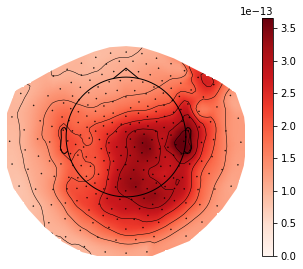

In [125]:
topomap(avg_power.copy().crop(tmin=0.35, tmax=0.45, fmin=20, fmax=30).data.mean(-1).mean(-1), mne.pick_info(info, sel=picks));

Removing 5 compensators from info because not all compensation channels were picked.


/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/lacnsg/hugwei/.conda/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


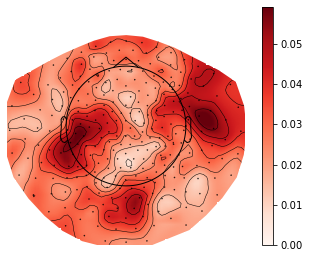

In [137]:
topomap(avg_itc.copy().crop(tmin=0.1, tmax=0.3, fmin=4, fmax=9).data.mean(-1).mean(-1), mne.pick_info(info, sel=picks));

Applying baseline correction (mode: ratio)


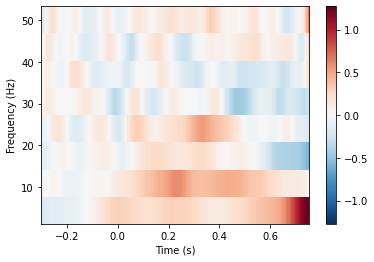

[<Figure size 432x288 with 2 Axes>]

In [127]:
avg_power.plot(baseline=(-.3, 0), mode='ratio', tmin=-0.3, tmax=0.75, picks=[182], dB=True)

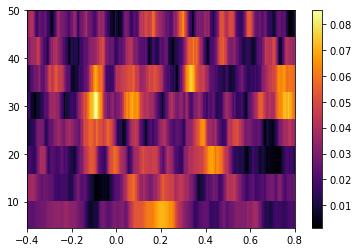

In [139]:
im = plt.imshow(avg_itc.data[230], aspect='auto', origin='lower', extent=[timefreq.times[0], timefreq.times[-1], timefreq.freqs[0], timefreq.freqs[-1]], cmap='inferno', interpolation='none')
plt.colorbar(im)

## Single Subject

In [11]:
tmin, tmax = -0.2, 0.6
trf = TRFEstimator(tmin=tmin, tmax=tmax, srate=fs, alpha=[1e-5])
trf_null = TRFEstimator(tmin=tmin, tmax=tmax, srate=fs, alpha=[1e-5])
lengths = [min(len(r), len(x)) for r,x in zip(raws, X)]


trf.fit([x[:l] for x,l in zip(X, lengths)], [r.get_data().T[:l] for r,l in zip(raws, lengths)], drop=False);
trf_null.fit([x[:l] for x,l in zip(Xnoise, lengths)], [r.get_data().T[:l] for r,l in zip(raws, lengths)], drop=False);

In [12]:
r = np.mean([(trf.score(x[:min(len(r), len(x))], r.get_data().T[:min(len(r), len(x))])) for (x, r) in zip(X, raws)], 0)
r_null = np.mean([(trf_null.score(x[:min(len(r), len(x))], r.get_data().T[:min(len(r), len(x))])) for (x, r) in zip(X, raws)], 0)

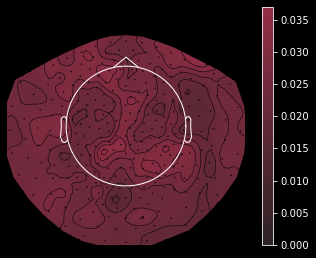

In [13]:
with plt.style.context("my_dark"):
    topomap(abs(r)-abs(r_null), info=raws[0].info, vmin=0., cmap=dark_blood);

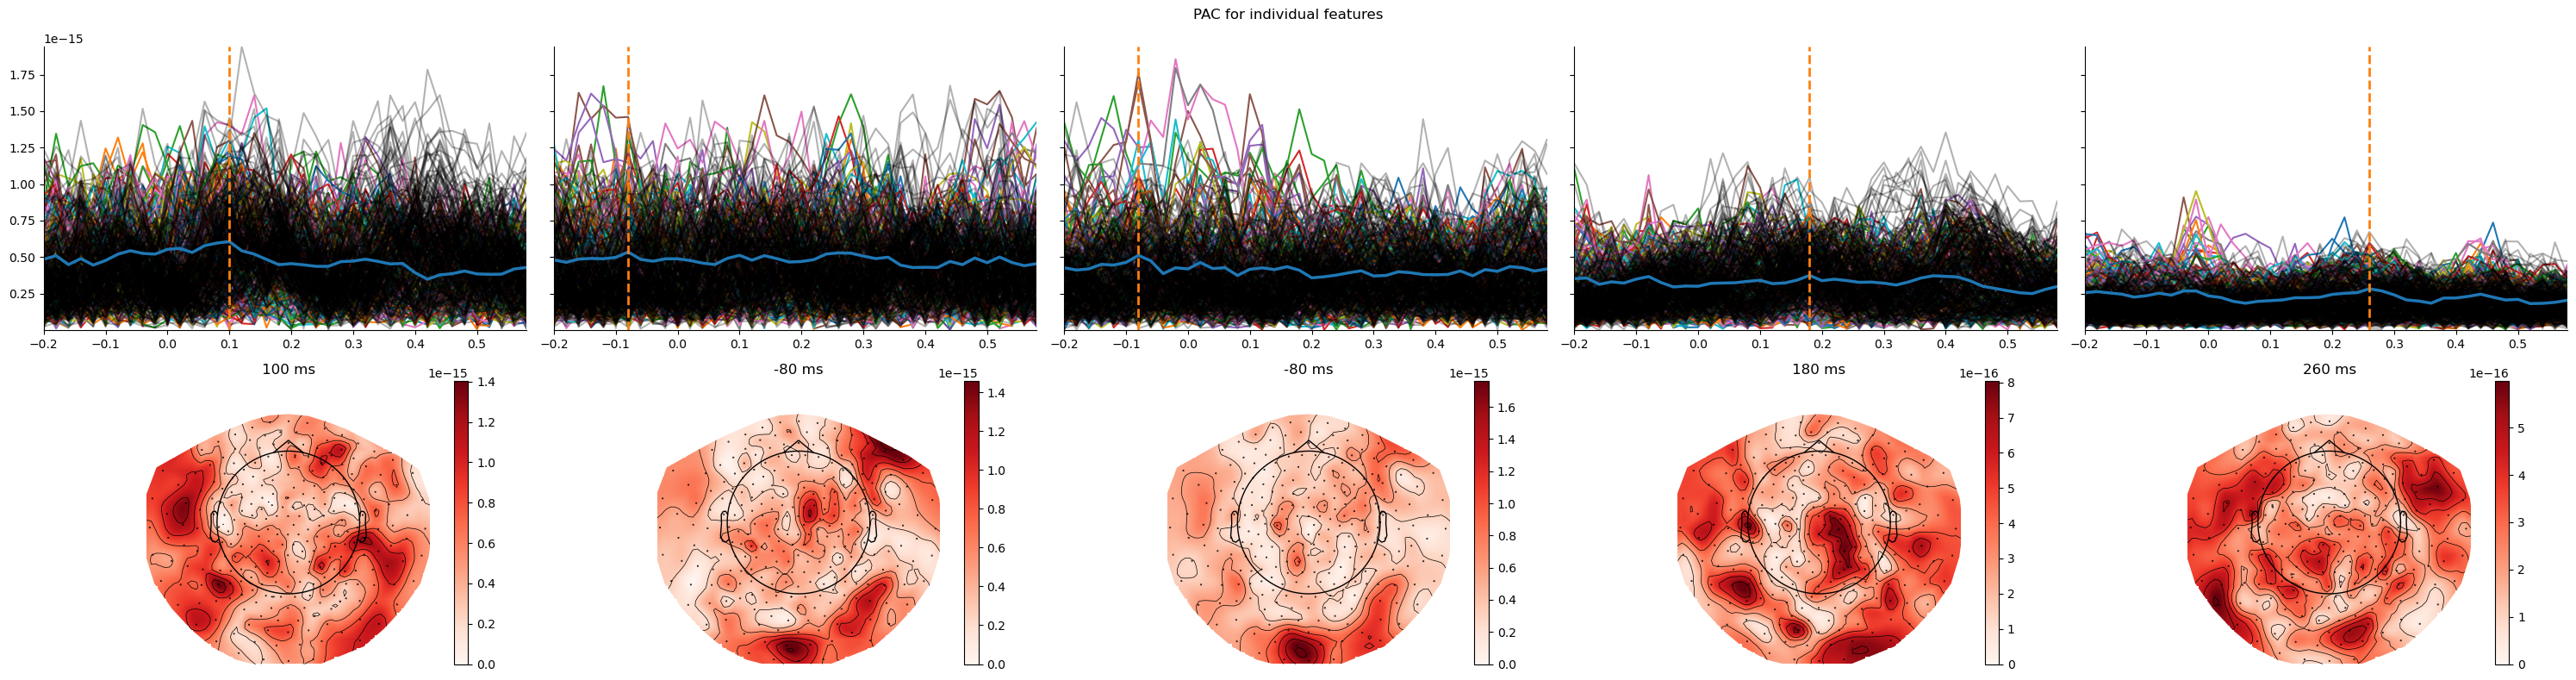

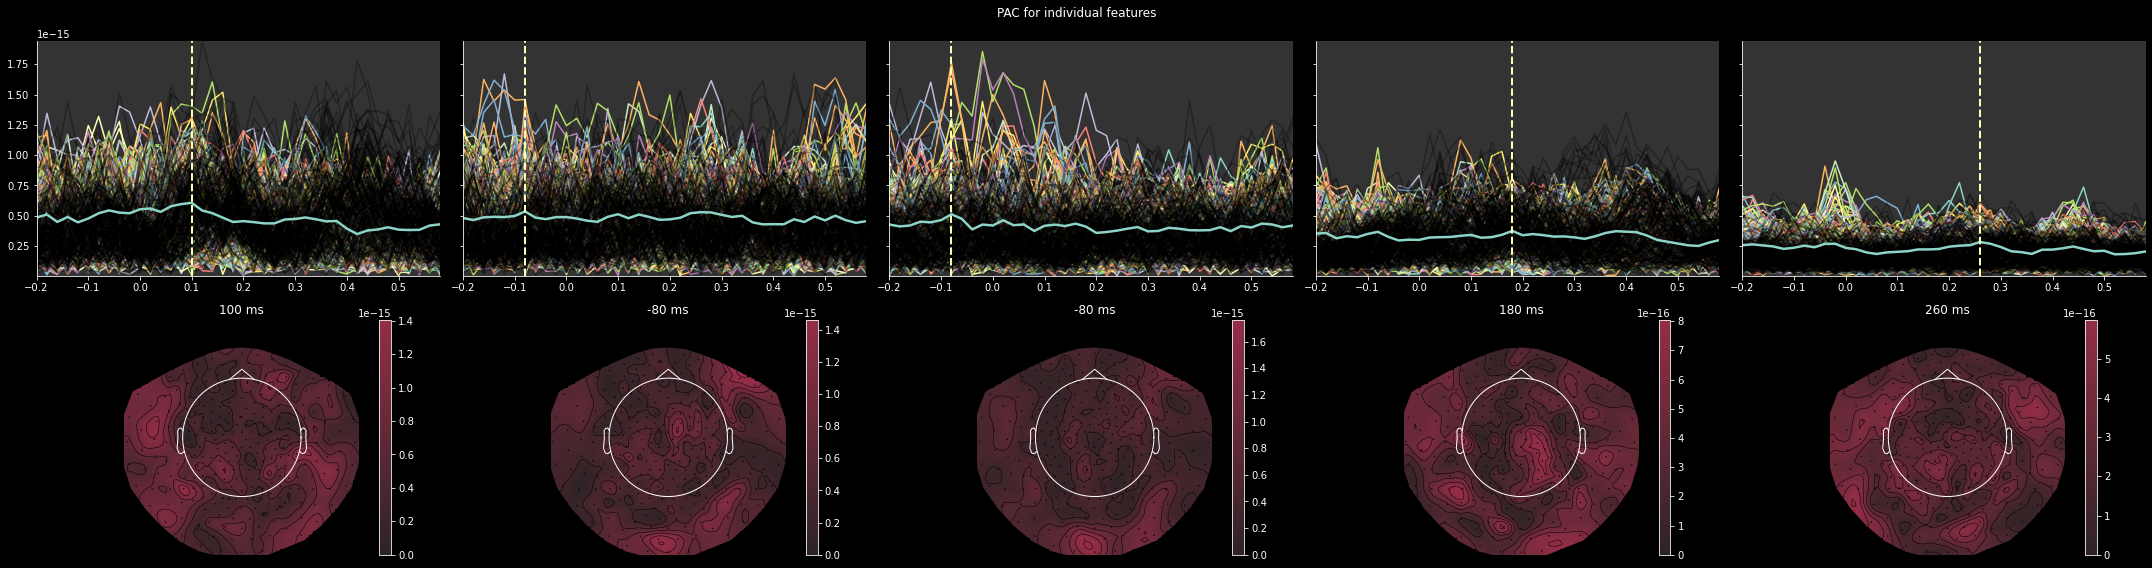

In [14]:
for context in ['default', 'my_dark']:
    with plt.style.context([context, {'axes.xmargin':0., 'axes.ymargin':0.}]):
        lines_colour_cycle = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
        f, axes = plt.subplots(2, trf.n_feats_, figsize=(6*trf.n_feats_, 8), sharey='row')
        ax, axtopo = axes
        for k in range(trf.n_feats_):
            ax[k].plot(trf.times, abs(trf.coef_[:, k, :]))
            ax[k].plot(trf.times, abs(trf_null.coef_[:, k, :]), alpha=0.3, color='k')
            # GFP
            ax[k].plot(trf.times, np.sqrt((abs(trf.coef_[:, k, :])**2).mean(-1)), color=lines_colour_cycle[0], lw=2.5)
            sns.despine(ax=ax[k])
            # Find peak
            peaks, props = find_peaks(np.sqrt((abs(trf.coef_[:, k, :])**2).mean(-1)), height=(None, None))
            idx = peaks[np.argmax(props['peak_heights'])] #  highest peak
            ax[k].axvline(trf.times[idx], color=lines_colour_cycle[1], lw=2, ls='--')
            topomap(abs(trf.coef_[idx, k, :]), raws[0].info, cmap=dark_blood if context=='my_dark' else 'Reds', vmin=0., ax=axtopo[k])
            axtopo[k].set_title(f"{trf.times[idx]*1e3:.0f} ms")

        f.suptitle("PAC for individual features")
        f.tight_layout()
        f.savefig("Results/PAC/TRF_PAC_features_" + context + "_thetaGamma.png")
        f.savefig("Results/PAC/TRF_PAC_features_" + context + "_thetaGamma.pdf")

## Across all subject - main loop

In [10]:
from functools import reduce

### Computing covariance matrices for PAC analytical signals

Will compute the convariance matrices for both the real and imaginary part of the analytical signal.

In [11]:
from mne import compute_raw_covariance

In [30]:
tmin, tmax = -0.2, 0.7
fs = 50
use_icaed = True
fbands = {'delta':(0.5, 4.5), 'theta':(4., 8.),
          'beta':(15, 30), 'gamma':(35, 80)}
high_osc = 'gamma'
low_osc = 'theta'
pac_name = '_'.join([low_osc, high_osc])

t = tqdm(enumerate(SUBJECTS), total=len(SUBJECTS))
cov_result = {}
for ksub, subject in t:
    if subject=='sub-002': continue

    t.set_description(f"Loading data for subject {subject}")
    try:
        raws = get_meg_xfreq_data(subject, fs, low=fbands[low_osc], high=fbands[high_osc], use_icaed=use_icaed)
        lengths = [min(len(r), len(x)) for r,x in zip(raws, X)]
        
    except:
        print(f"Error in loading for {subject}. Skipping.")
        continue
        
    # Compute covariance matrices:
    cov_result[subject] = {}
    # maybe I just need the complex covariance matrix?
    cov_result[subject]['real'] = compute_raw_covariance(mne.concatenate_raws([r.copy().apply_function(np.real, dtype=float) for r in raws]))
    cov_result[subject]['imag'] = compute_raw_covariance(mne.concatenate_raws([r.copy().apply_function(np.imag, dtype=float) for r in raws]))
    
    # Save data:
    mne.cov.write_cov(f'Data/{subject}_{low_osc}_{high_osc}_REAL-cov.fif', cov_result[subject]['real'])
    mne.cov.write_cov(f'Data/{subject}_{low_osc}_{high_osc}_IMAG-cov.fif', cov_result[subject]['imag'])

Loading data for subject sub-003:   0%|          | 0/30 [00:00<?, ?it/s]/home/lacnsg/hugwei/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Loading data for subject sub-004:   3%|▎         | 1/30 [01:48<52:25, 108.47s/it]

Error in loading for sub-003. Skipping.


Loading data for subject sub-001:   7%|▋         | 2/30 [02:12<27:18, 58.53s/it] 

Error in loading for sub-004. Skipping.


Loading data for subject sub-008:  13%|█▎        | 4/30 [02:54<15:16, 35.24s/it]

Error in loading for sub-001. Skipping.
Error in loading for sub-030. Skipping.


Loading data for subject sub-009:  20%|██        | 6/30 [03:27<10:30, 26.28s/it]

Error in loading for sub-008. Skipping.
Error in loading for sub-006. Skipping.


Loading data for subject sub-010:  27%|██▋       | 8/30 [04:06<08:37, 23.52s/it]

Error in loading for sub-009. Skipping.


Loading data for subject sub-011:  30%|███       | 9/30 [04:48<09:41, 27.67s/it]

Error in loading for sub-010. Skipping.


Loading data for subject sub-013:  33%|███▎      | 10/30 [05:25<10:00, 30.02s/it]

Error in loading for sub-011. Skipping.


Loading data for subject sub-024:  37%|███▋      | 11/30 [06:04<10:12, 32.25s/it]

Error in loading for sub-013. Skipping.


Loading data for subject sub-018:  40%|████      | 12/30 [06:55<11:11, 37.29s/it]

Error in loading for sub-024. Skipping.


Loading data for subject sub-019:  43%|████▎     | 13/30 [07:31<10:30, 37.08s/it]

Error in loading for sub-018. Skipping.


Loading data for subject sub-005:  47%|████▋     | 14/30 [08:06<09:43, 36.44s/it]

Error in loading for sub-019. Skipping.


Loading data for subject sub-020:  50%|█████     | 15/30 [08:43<09:05, 36.39s/it]

Error in loading for sub-005. Skipping.


Loading data for subject sub-021:  53%|█████▎    | 16/30 [09:22<08:40, 37.17s/it]

Error in loading for sub-020. Skipping.


Loading data for subject sub-023:  57%|█████▋    | 17/30 [10:00<08:06, 37.42s/it]

Error in loading for sub-021. Skipping.


Loading data for subject sub-027:  60%|██████    | 18/30 [10:38<07:30, 37.56s/it]

Error in loading for sub-023. Skipping.


Loading data for subject sub-014:  63%|██████▎   | 19/30 [11:17<07:00, 38.23s/it]

Error in loading for sub-027. Skipping.


Loading data for subject sub-025:  67%|██████▋   | 20/30 [11:56<06:22, 38.24s/it]

Error in loading for sub-014. Skipping.


Loading data for subject sub-026:  70%|███████   | 21/30 [12:37<05:53, 39.23s/it]

Error in loading for sub-025. Skipping.


Loading data for subject sub-015:  73%|███████▎  | 22/30 [13:02<04:40, 35.01s/it]

Error in loading for sub-026. Skipping.


Loading data for subject sub-028:  77%|███████▋  | 23/30 [13:44<04:19, 37.12s/it]

Error in loading for sub-015. Skipping.


Loading data for subject sub-029:  80%|████████  | 24/30 [14:20<03:40, 36.81s/it]

Error in loading for sub-028. Skipping.


Loading data for subject sub-032:  83%|████████▎ | 25/30 [15:01<03:09, 37.82s/it]

Error in loading for sub-029. Skipping.


Loading data for subject sub-033:  87%|████████▋ | 26/30 [15:52<02:47, 41.77s/it]

Error in loading for sub-032. Skipping.


Loading data for subject sub-017:  90%|█████████ | 27/30 [16:30<02:01, 40.63s/it]

Error in loading for sub-033. Skipping.
Error in loading for sub-007. Skipping.


Loading data for subject sub-034: 100%|██████████| 30/30 [17:12<00:00, 34.41s/it]

Error in loading for sub-017. Skipping.
Error in loading for sub-034. Skipping.


### Computing PAC - TRF and scoring them (x-validated: one story out)

In [227]:
tmin, tmax = -0.2, 0.7
fs = 50
trf = TRFEstimator(tmin=tmin, tmax=tmax, srate=fs, alpha=1e-4) # 1e4 for orignal envwhich_score, maybe a bit less for derivative?
trf_null = TRFEstimator(tmin=tmin, tmax=tmax, srate=fs, alpha=1e-4)

use_icaed = True

fbands = {'delta':(0.5, 4.5), 'theta':(4., 8.),
          'beta':(15, 30), 'gamma':(35, 80)}
high_osc = 'beta'
low_osc = 'delta'
pac_name = '_'.join([low_osc, high_osc])

scores = pd.DataFrame(columns=['score_rel', 'score', 'score_null', 'subj'])
coupl = pd.DataFrame(columns=['feat', 'subj', 'coupling', 'baseline', 'null'])
all_trfs = []
all_trf_nulls = []
t = tqdm(enumerate(SUBJECTS[18:]), total=len(SUBJECTS[18:]))
for ksub, subject in t:
    if subject=='sub-002': continue

    t.set_description(f"Loading data for subject {subject}")
    try:
        raws = get_meg_xfreq_data(subject, fs, low=fbands[low_osc], high=fbands[high_osc])
        lengths = [min(len(r), len(x)) for r,x in zip(raws, X)]
    except:
        print(f"Error in loading for {subject}. Skipping.")
        continue

    scores_oneout = []
    scores_null = []
    story_trfs = []
    story_trfs_null = []
    t.set_description("Computing encoding models...")
    for kstory, x,r,length in zip(range(len(X)), X, raws, lengths):
        # Fit true model
        trf.fit([xx[:l] for k, (xx, l) in enumerate(zip(X, lengths)) if k != kstory],
                [rr.get_data().T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
        story_trfs.append(trf)
        scores_oneout.append(np.abs(trf.score(x[:length], r.get_data().T[:length], reduce_multi='mean')))
        # Fit and score NULL MODEL
        trf_null.fit([xx[:l] for k, (xx, l) in enumerate(zip(Xnoise, lengths)) if k != kstory],
                [rr.get_data().T[:l] for k, (rr, l) in enumerate(zip(raws, lengths)) if k!=kstory], drop=False)
        story_trfs_null.append(trf_null)
        scores_null.append(np.abs(trf_null.score(x[:length], r.get_data().T[:length], reduce_multi='mean')))
    # Append subject's trf and save it to file
    all_trfs.append(reduce(lambda x,y:x+y, story_trfs))
    all_trf_nulls.append(reduce(lambda x,y:x+y, story_trfs_null))
    reduce(lambda x,y:x+y, story_trfs).save(f'Data/{subject}_{low_osc}_{high_osc}.npz')
    reduce(lambda x,y:x+y, story_trfs_null).save(f'Data/{subject}_{low_osc}_{high_osc}_null.npz')

    # average across all stories for scores (and take last trained trf - across all but one story for coefficients/coupling values)
    baseline = np.argwhere(trf.times <0.)
    postimes = np.argwhere(trf.times >0.)
    coupling = np.mean(abs(trf.coef_[postimes, ...]), 0).mean(-1).squeeze()
    null_coupling = np.mean(abs(trf_null.coef_[postimes, ...]), 0).mean(-1).squeeze()
    base_coupling = np.mean(abs(trf.coef_[baseline, ...]), 0).mean(-1).squeeze()
    tmp = pd.DataFrame(columns=['score_rel', 'score', 'score_null', 'subj'])
    tmp.score_rel = [np.mean(scores_oneout)-np.mean(scores_null)] # store increment beyond null model
    tmp.score_null = [np.mean(scores_null)]
    tmp.score = [np.mean(scores_oneout)]
    tmp.subj = [subject]
    scores = pd.concat([scores, tmp], ignore_index=True)
    tmp = pd.DataFrame(columns=['feat', 'subj', 'coupling', 'baseline', 'null'])
    tmp.subj = [subject]*5
    tmp.feat = ['w', 'e', 's', 'd', 'c']
    tmp.coupling = coupling
    tmp.baseline = base_coupling
    tmp.null = null_coupling
    coupl = pd.concat([coupl, tmp], ignore_index=True)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
for k, sub in enumerate(coupl.subj.unique()):
    reduce(lambda x,y:x+y, all_trfs[k*9:(k+1)*9]).save(f'Data/{sub}_{low_osc}_{high_osc}.npz')
    reduce(lambda x,y:x+y, all_trf_nulls[k*9:(k+1)*9]).save(f'Data/{sub}_{low_osc}_{high_osc}_null.npz')

In [11]:
from functools import reduce
testtrf = reduce(lambda x,y:x+y, all_trfs)
#testtrf.save("test_all_subj_trf_" + pac_name)
#reduce(lambda x,y: x+y, all_trf_nulls)#.save("test_all_null_trfs_" + pac_name)

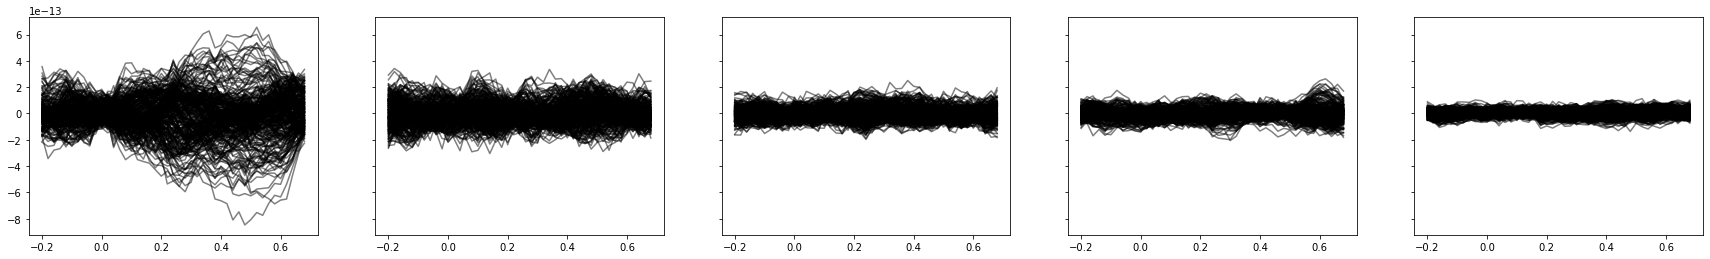

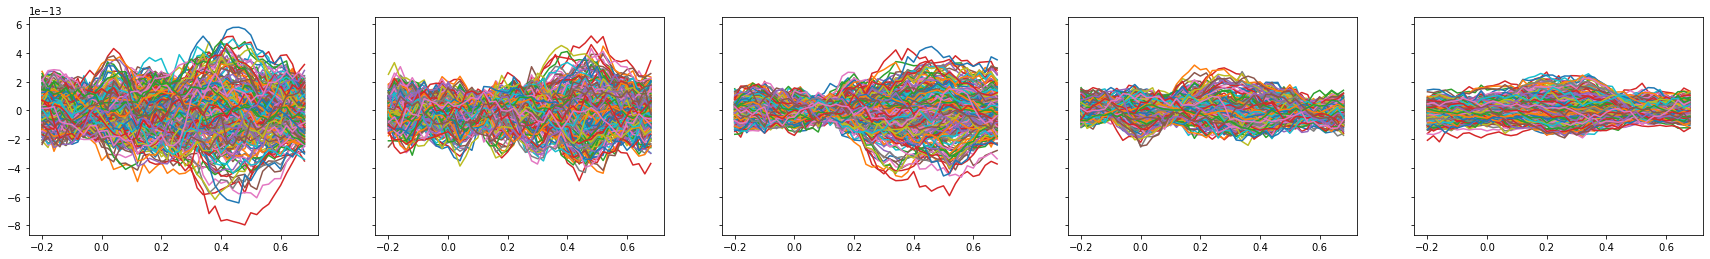

In [24]:
reduce(lambda x,y: x+y, all_trf_nulls).apply_func(np.real).plot(sharey=True);
axes = plt.gcf().get_axes()
for a in axes:
    for l in a.get_lines():
        l.set_color('k')
        l.set_alpha(0.5)
reduce(lambda x,y: x+y, all_trfs).apply_func(np.real).plot(sharey=True);

In [56]:
scores.to_csv("coupling_score_newX_revampedPreproc_" + pac_name + ".csv")
coupl.to_csv("coupling_coefs_newX_revampedPreproc_" + pac_name + ".csv")

In [3]:
scores = pd.read_csv("Data/coupling_score_newX_revampedPreproc_theta_gamma.csv") # pd.read_csv("coupling_score.csv")
# coupl = pd.read_csv("coupling_coefs_newX_revampedPreproc") #coupling_coefs.csv")

In [4]:
scores = scores.drop(columns='Unnamed: 0')

<AxesSubplot:>

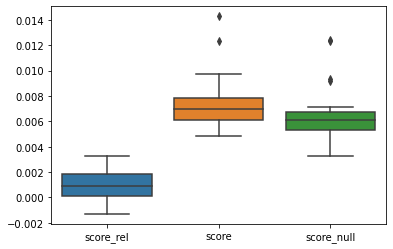

In [5]:
sns.boxplot(data=scores)

In [62]:
pcrit = 0.00001
ntests = len(coupl.feat.unique())*3
for f in coupl.feat.unique():
    print(f"{f}")
    print(f"Relative to baseline feature {f}:\t{Fore.RED if ttest_rel(coupl.loc[coupl.feat==f, 'coupling'], coupl.loc[coupl.feat==f, 'baseline']).pvalue*ntests > pcrit else Fore.GREEN}{ttest_rel(coupl.loc[coupl.feat==f, 'coupling'], coupl.loc[coupl.feat==f, 'baseline']).pvalue*ntests:.1e}{Fore.RESET}")
    print(f"Relative to null feature {f}:\t{Fore.RED if ttest_rel(coupl.loc[coupl.feat==f, 'coupling'], coupl.loc[coupl.feat==f, 'null']).pvalue*ntests > pcrit else Fore.GREEN}{ttest_rel(coupl.loc[coupl.feat==f, 'coupling'], coupl.loc[coupl.feat==f, 'null']).pvalue*ntests:.1e}{Fore.RESET}")
    print(f"Relative to zero, {f}:\t\t{Fore.RED if ttest_1samp(coupl.loc[coupl.feat==f, 'coupling'], 0).pvalue*ntests > pcrit else Fore.GREEN}{ttest_1samp(coupl.loc[coupl.feat==f, 'coupling'], 0).pvalue*ntests:.1e}{Fore.RESET}")
    print("")

w
Relative to baseline feature w:	8.8e-04
Relative to null feature w:	5.1e-02
Relative to zero, w:		1.3e-18

e
Relative to baseline feature e:	3.1e-03
Relative to null feature e:	6.3e-09
Relative to zero, e:		1.7e-20

s
Relative to baseline feature s:	5.1e-11
Relative to null feature s:	1.0e-11
Relative to zero, s:		1.2e-18

d
Relative to baseline feature d:	3.2e-05
Relative to null feature d:	2.8e-07
Relative to zero, d:		1.9e-17

c
Relative to baseline feature c:	2.4e-08
Relative to null feature c:	3.0e-10
Relative to zero, c:		2.7e-16



In [39]:
from matplotlib.patches import PathPatch

In [40]:
def prettify_boxplot(ax):    
    patches = [p for p in ax.get_children() if isinstance(p, PathPatch)]
    lines = ax.get_lines()
    for k, p in enumerate(patches):
        c = p.get_facecolor()
        p.set_edgecolor(sns.desaturate(c, 0.65))
        # Vertical Edges
        lines[k*6].set_color(c)
        lines[k*6+1].set_color(c)
        # Caps
        lines[k*6+2].set_visible(False)
        lines[k*6+3].set_visible(False)
    #return ax

In [41]:
colors = [[0.6]*3+[1.], *sns.diverging_palette(280, 120, s=120, l=55, n=4)]

In [58]:
trf_null_abs = trf_null.copy()
trf_abs = trf.copy()
trf_abs.coef_ = abs(trf_abs.coef_)
trf_null_abs.coef_ = abs(trf_null_abs.coef_)

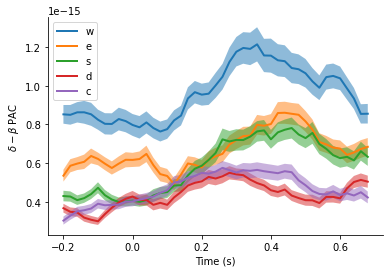

In [59]:
for f in range(trf.n_feats_):
    mu = np.sqrt((abs(trf.coef_[:, f, 20:])**2).mean(-1))
    plt.plot(trf.times, mu, lw=2, label=list('wesdc')[f]);
    sem = np.sqrt((abs(trf.coef_[:, f, 20:])**2).std(-1))/np.sqrt(267)
    plt.fill_between(trf.times, mu-sem, mu+sem, alpha=0.5);
    
plt.legend()
plt.ylabel("$\delta-\\beta$ PAC")
plt.xlabel("Time (s)")
sns.despine()

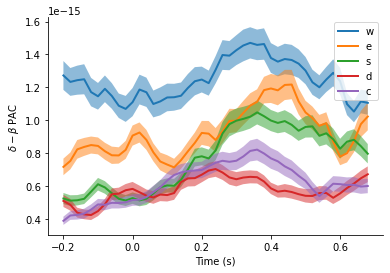

In [42]:
for f in range(trf.n_feats_):
    mu = np.sqrt((abs(trf.coef_[:, f, 20:])**2).mean(-1))
    plt.plot(trf.times, mu, lw=2, label=list('wesdc')[f]);
    sem = np.sqrt((abs(trf.coef_[:, f, 20:])**2).std(-1))/np.sqrt(267)
    plt.fill_between(trf.times, mu-sem, mu+sem, alpha=0.5);
    
plt.legend()
plt.ylabel("$\delta-\\beta$ PAC")
plt.xlabel("Time (s)")
sns.despine()
plt.savefig("Results/PAC/Another_curve_test_coupling_otherSubject_maybeOtherFeatX_otherSubj.png")

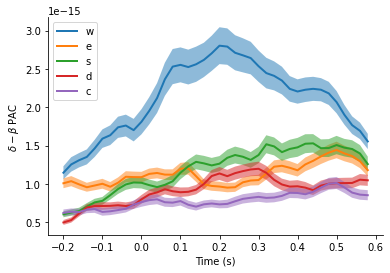

In [32]:
for f in range(trf.n_feats_):
    mu = np.sqrt((abs(trf.coef_[:, f, 20:])**2).mean(-1))
    plt.plot(trf.times, mu, lw=2, label=list('wesdc')[f]);
    sem = np.sqrt((abs(trf.coef_[:, f, 20:])**2).std(-1))/np.sqrt(267)
    plt.fill_between(trf.times, mu-sem, mu+sem, alpha=0.5);
    
plt.legend()
plt.ylabel("$\delta-\\beta$ PAC")
plt.xlabel("Time (s)")
sns.despine()
plt.savefig("Results/PAC/Another_curve_test_coupling_otherSubject_maybeOtherFeatX.png")

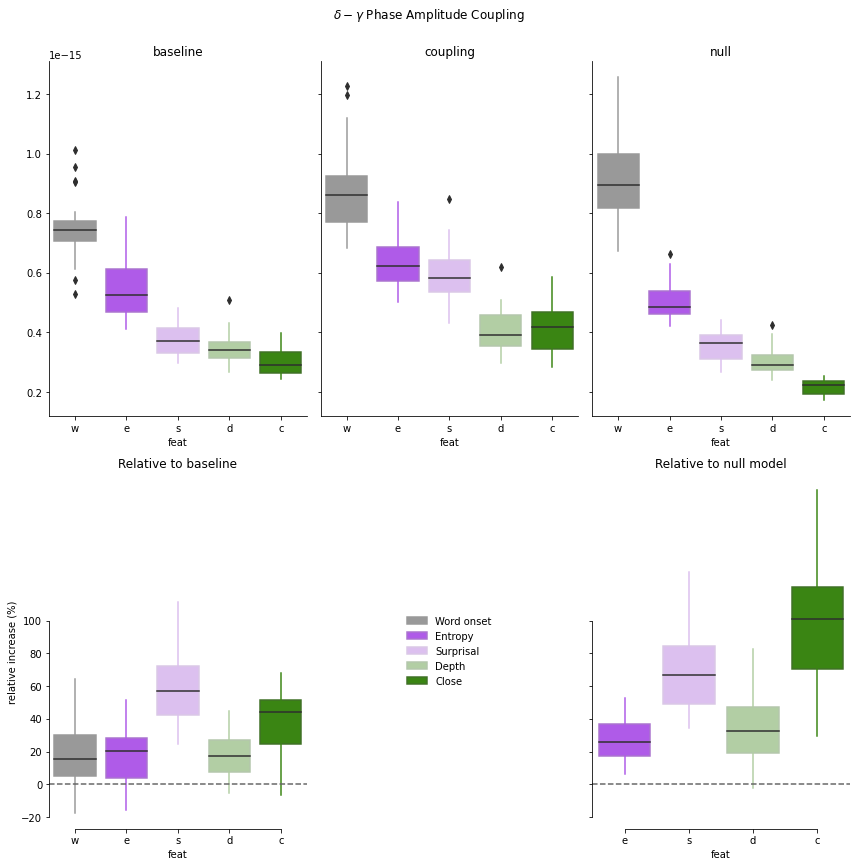

In [73]:
f, ax = plt.subplots(2, 3, figsize=(4 * 3, 12), sharey='row', constrained_layout=False)
for coup_type, aax in zip(['baseline', 'coupling', 'null'], ax[0]):
    aax = sns.boxplot(data=coupl, x='feat', y=coup_type, palette=colors, ax=aax)
    aax.set_title(aax.get_ylabel())
    aax.set_ylabel("")
    prettify_boxplot(aax)
    sns.despine(trim=False, ax=aax)
for coup_type, aax in zip(['baseline', 'null'], ax[1][::2]):
    if coup_type == 'baseline':
        aax = sns.boxplot(x=coupl.feat, y=(coupl.coupling-coupl.loc[:, coup_type])/coupl.loc[:, coup_type]*100, ax=aax, palette=colors)
        patches = [p for p in aax.get_children() if isinstance(p, PathPatch)]
        aax.set_title("Relative to baseline")
        aax.set_ylabel("relative increase (%)")
    else:
        aax = sns.boxplot(x=coupl.feat, y=(coupl.coupling-coupl.loc[:, coup_type])/coupl.loc[:, coup_type]*100, ax=aax, palette=colors[1:], order=['e', 's', 'd', 'c'])
        aax.set_title("Relative to null model")
    aax.axhline(color=[0.4]*3, ls='--')
    prettify_boxplot(aax)
    sns.despine(trim=True, ax=aax)
# Use empty axis for legend
ax[-1,1].legend(patches, ['Word onset', 'Entropy', 'Surprisal', 'Depth', 'Close'], loc='center', frameon=False)
# hide axes
ax[-1, 1].axis(False)
f.suptitle("$\delta - \gamma$ Phase Amplitude Coupling", y=1.)
f.tight_layout()
f.savefig("couplingPAC_50Hz_allSubj_WEDSC_new_" + pac_name + ".png")
f.savefig("couplingPAC_50Hz_allSubj_WEDSC_new_" + pac_name + ".pdf")

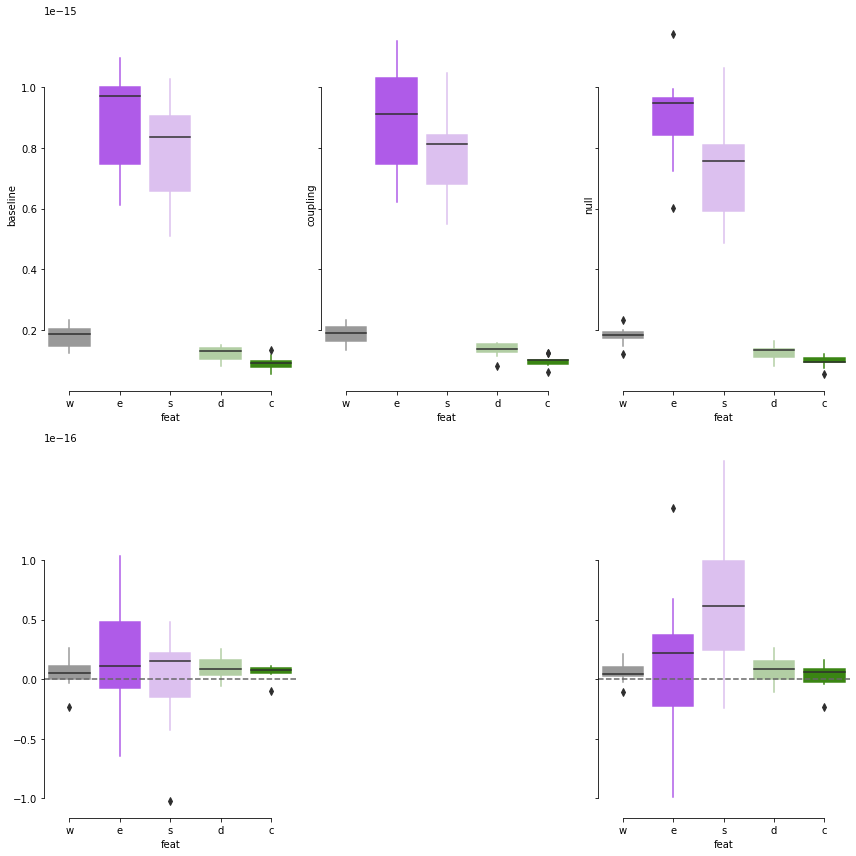

In [154]:
f, ax = plt.subplots(2, 3, figsize=(4 * 3, 12), sharey='row', constrained_layout=False)
for coup_type, aax in zip(['baseline', 'coupling', 'null'], ax[0]):
    aax = sns.boxplot(data=coupl, x='feat', y=coup_type, palette=colors, ax=aax)
    prettify_boxplot(aax)
    sns.despine(trim=True, ax=aax)
ax[-1, 1].remove()
for coup_type, aax in zip(['baseline', 'null'], ax[1][::2]):
    aax = sns.boxplot(x=coupl.feat, y=coupl.coupling-coupl.loc[:, coup_type], ax=aax, palette=colors)
    aax.axhline(color=[0.4]*3, ls='--')
    prettify_boxplot(aax)
    sns.despine(trim=True, ax=aax)
f.tight_layout()